In [5]:
import os
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

In [11]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

1 Physical GPUs, 1 Logical GPU
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


In [12]:
def load_data(train_directory, test_directory):
    X_train, y_train, X_test, y_test = [], [], [], []
    labels = os.listdir(train_directory)

    for i, label in enumerate(labels):
        folderpath_train = os.path.join(train_directory, label)
        folderpath_test = os.path.join(test_directory, label)

        for file in os.listdir(folderpath_train):
            img = cv.imread(os.path.join(folderpath_train, file))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (128, 128))
            X_train.append(np.array(img))
            y_train.append(i)

        for file in os.listdir(folderpath_test):
            img = cv.imread(os.path.join(folderpath_test, file))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (128, 128))
            X_test.append(np.array(img))
            y_test.append(i)

    X_train = np.array(X_train) / 255.0
    y_train = np.array(y_train)
    X_test = np.array(X_test) / 255.0
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test, labels

In [13]:
train_directory = 'data/training/'
test_directory = 'data/files_for_testing/'
X_train, y_train, X_test, y_test, labels = load_data(train_directory, test_directory)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4352, 128, 128, 3), (4352,), (295, 128, 128, 3), (295,))

<function matplotlib.pyplot.show(close=None, block=None)>

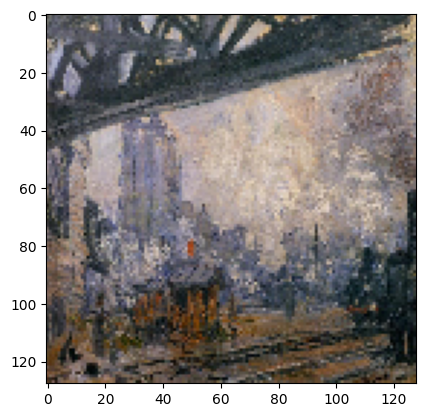

In [15]:
num_img = 1000

plt.imshow(X_train[num_img])
plt.show

In [16]:
print(labels[y_train[num_img]])

Monet


In [17]:
def objective(params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        random_state=42
    )
    
    model.fit(X_train.reshape(len(X_train), -1), y_train)
    y_pred = model.predict(X_test.reshape(len(X_test), -1))
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy

In [18]:
space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200, 400, 300]),
    'max_depth': hp.choice('max_depth', [10, 20, 12, 30, None]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10, 15, 3])
}

In [21]:
import GPUtil

GPUs = GPUtil.getGPUs()
for gpu in GPUs:
    print(f"GPU id: {gpu.id}, Name: {gpu.name}, Load: {gpu.load*100}%, Free memory: {gpu.memoryFree}MB, Used memory: {gpu.memoryUsed}MB, Total memory: {gpu.memoryTotal}MB, Driver Version: {gpu.driver}")


GPU id: 0, Name: NVIDIA GeForce RTX 3060 Laptop GPU, Load: 2.0%, Free memory: 5041.0MB, Used memory: 956.0MB, Total memory: 6144.0MB, Driver Version: 551.76


In [22]:
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [3:05:25<00:00, 222.52s/trial, best loss: -0.6203389830508474]  


In [23]:
best_params = {
    'n_estimators': [50, 100, 200, 400, 300][best['n_estimators']],
    'max_depth': [10, 20, 12, 30, None][best['max_depth']],
    'min_samples_split': [2, 5, 10, 15, 3][best['min_samples_split']]
}

print("Najlepsze hiperparametry:", best_params)

Najlepsze hiperparametry: {'n_estimators': 400, 'max_depth': 30, 'min_samples_split': 2}


In [24]:
best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   min_samples_split=best_params['min_samples_split'],
                                   random_state=42)

best_model.fit(X_train.reshape(len(X_train), -1), y_train)

RandomForestClassifier(max_depth=30, n_estimators=400, random_state=42)

In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

print(class_weight_dict)

{0: 1.325616813889735, 1: 8.074211502782932, 2: 0.6065505226480836, 3: 4.258317025440313, 4: 4.819490586932448, 5: 0.5870767570484284, 6: 0.42965741929114426}


In [26]:
best_model = RandomForestClassifier(n_estimators=400,
                                   max_depth=30,
                                   min_samples_split=2,
                                   random_state=42,
                                   class_weight=class_weight_dict)

best_model.fit(X_train.reshape(len(X_train), -1), y_train)

RandomForestClassifier(class_weight={0: 1.325616813889735, 1: 8.074211502782932,
                                     2: 0.6065505226480836,
                                     3: 4.258317025440313, 4: 4.819490586932448,
                                     5: 0.5870767570484284,
                                     6: 0.42965741929114426},
                       max_depth=30, n_estimators=400, random_state=42)

In [33]:
import joblib
import zipfile

joblib.dump(best_model, 'random_forest.pkl')


with zipfile.ZipFile('random_forest.zip', 'w') as zipf:
    zipf.write('random_forest.pkl', os.path.basename('random_forest.pkl'))

In [ ]:
with zipfile.ZipFile('random_forest.zip', 'r') as zipf:
    zipf.extractall()

loaded_model = joblib.load('random_forest.pkl')


In [27]:
y_pred = best_model.predict(X_test.reshape(len(X_test), -1))
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji: 59.66%


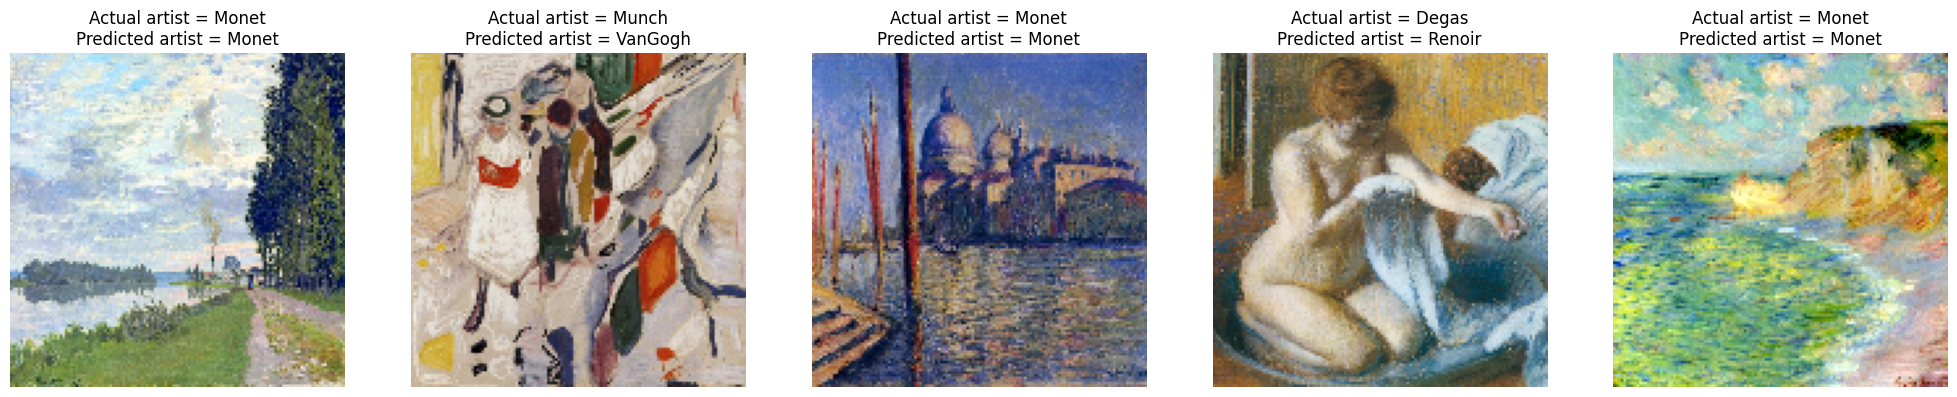

In [28]:
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt

n = 5
fig, axes = plt.subplots(1, n, figsize=(25, 10))

for i in range(n):
    random_artist = random.choice(labels)
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    # Oryginalny obraz
    test_image = plt.imread(random_image_file)

    # Prognozuj artystę
    test_image = cv.resize(test_image, (128, 128))
    test_image = np.array(test_image) / 255
    prediction = best_model.predict(test_image.reshape(1, -1))
    prediction_artist = labels[prediction[0]]

    title = "Actual artist = {}\nPredicted artist = {}".format(random_artist.replace('_', ' '), prediction_artist.replace('_', ' '))

    # Wyświetl obraz
    axes[i].imshow(test_image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

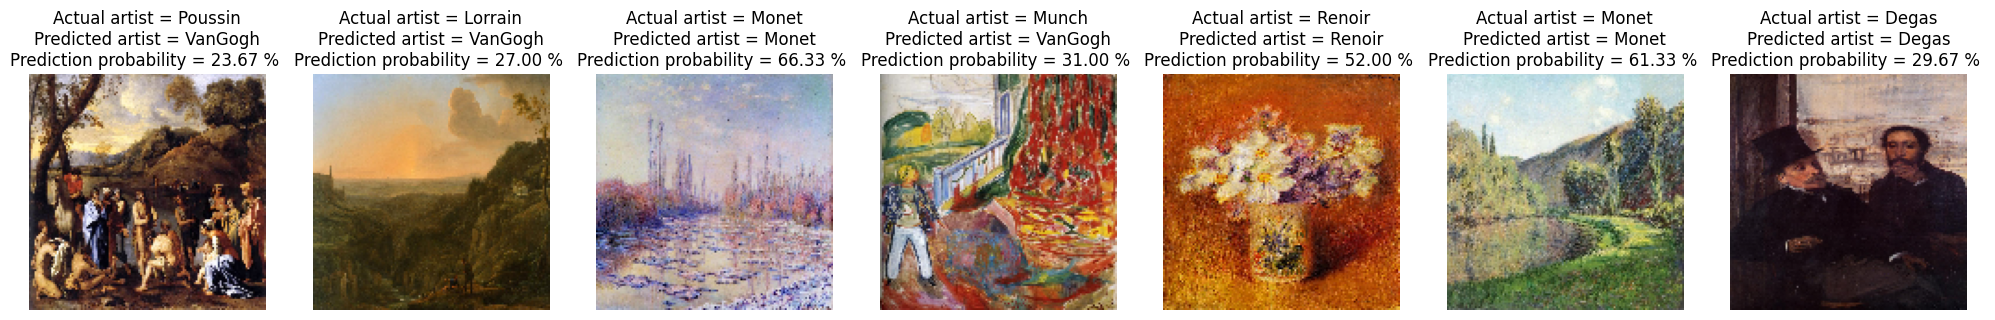

In [28]:
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))


for i in range(n):
    random_artist = random.choice(labels)
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = plt.imread(random_image_file)

    test_image = cv.resize(test_image, (128, 128))
    test_image = np.array(test_image) / 255
    prediction = best_model.predict(test_image.reshape(1, -1))
    prediction_artist = labels[prediction[0]]

    prediction_probabilities = best_model.predict_proba(test_image.reshape(1, -1))[0]
    max_probability = max(prediction_probabilities)  
    prediction_idx = prediction_probabilities.argmax()  

    title = "Actual artist = {}\nPredicted artist = {}\n".format(random_artist.replace('_', ' '), prediction_artist.replace('_', ' '))
    title += "Prediction probability = {:.2f} % ".format(max_probability * 100)


    # Display the image
    axes[i].imshow(test_image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()


c:\Users\Administrator\anaconda3\envs\master_thesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\anaconda3\envs\master_thesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\anaconda3\envs\master_thesis\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

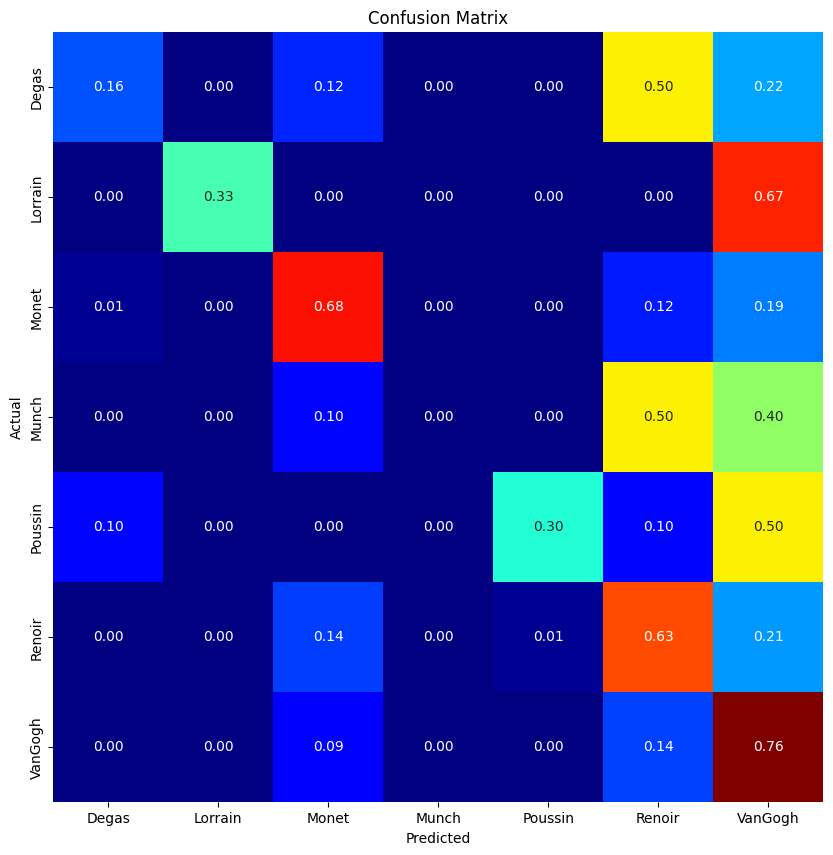

Classification Report:
              precision    recall  f1-score   support

       Degas       0.71      0.16      0.26        32
     Lorrain       1.00      0.33      0.50         6
       Monet       0.66      0.68      0.67        69
       Munch       0.00      0.00      0.00        10
     Poussin       0.75      0.30      0.43        10
      Renoir       0.51      0.63      0.56        71
     VanGogh       0.61      0.76      0.68        97

    accuracy                           0.60       295
   macro avg       0.61      0.41      0.44       295
weighted avg       0.60      0.60      0.57       295



In [29]:
import seaborn as sns

y_pred = best_model.predict(X_test.reshape(len(X_test), -1))
accuracy = classification_report(y_test, y_pred, target_names=labels)
conf_matrix = confusion_matrix(y_test, y_pred)

row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = (conf_matrix / row_sums) 

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", square=True, cbar=False, cmap=plt.cm.jet, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:')
print(accuracy)

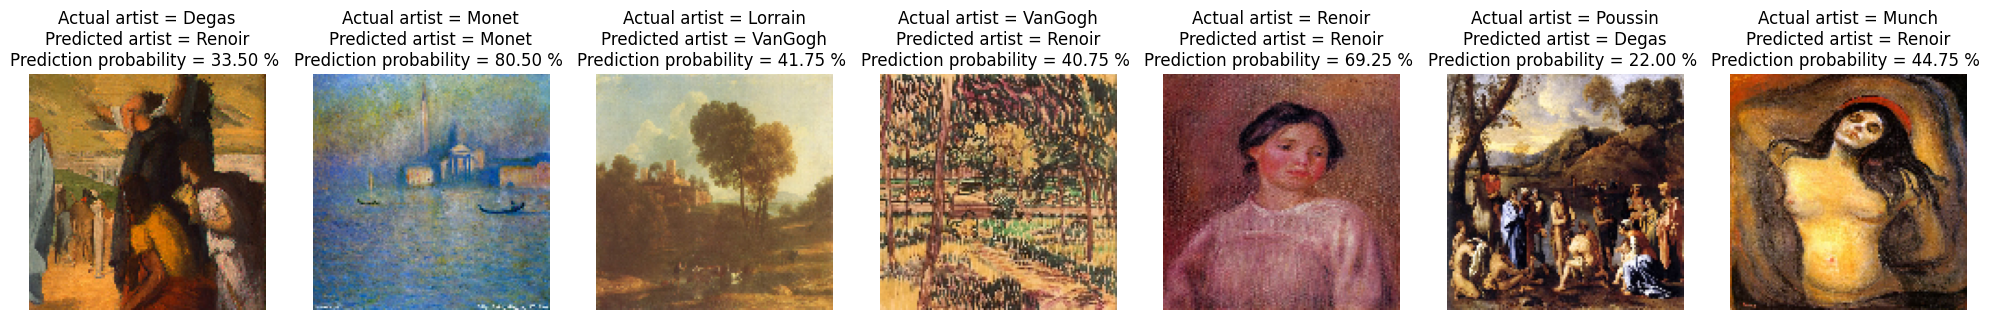

In [31]:
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))

unique_artists = list(set(labels))

for i in range(n):
    random_artist = random.choice(unique_artists)
    unique_artists.remove(random_artist)

    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = plt.imread(random_image_file)

    test_image = cv.resize(test_image, (128, 128))
    test_image = np.array(test_image) / 255
    prediction = best_model.predict(test_image.reshape(1, -1))
    prediction_artist = labels[prediction[0]]

    prediction_probabilities = best_model.predict_proba(test_image.reshape(1, -1))[0]
    max_probability = max(prediction_probabilities)  
    prediction_idx = prediction_probabilities.argmax() 

    title = "Actual artist = {}\nPredicted artist = {}\n".format(random_artist.replace('_', ' '), prediction_artist.replace('_', ' '))
    title += "Prediction probability = {:.2f} % ".format(max_probability * 100)

    axes[i].imshow(test_image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()


In [34]:
import zipfile
import joblib
import os
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf

def load_data(train_directory, test_directory):
    X_train, y_train, X_test, y_test = [], [], [], []
    labels = os.listdir(train_directory)

    for i, label in enumerate(labels):
        folderpath_train = os.path.join(train_directory, label)
        folderpath_test = os.path.join(test_directory, label)

        for file in os.listdir(folderpath_train):
            img = cv.imread(os.path.join(folderpath_train, file))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (128, 128))
            X_train.append(np.array(img))
            y_train.append(i)

        for file in os.listdir(folderpath_test):
            img = cv.imread(os.path.join(folderpath_test, file))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (128, 128))
            X_test.append(np.array(img))
            y_test.append(i)

    X_test = np.array(X_test) / 255.0
    y_test = np.array(y_test)

    return X_test, y_test, labels



In [35]:
train_directory = 'data/training/'
test_directory = 'data/files_for_testing/'
X_test, y_test, labels = load_data(train_directory, test_directory)


1


In [37]:
with zipfile.ZipFile('random_forest.zip', 'r') as zipf:
    zipf.extractall()

loaded_model = joblib.load('random_forest.pkl')

y_pred = loaded_model.predict(X_test.reshape(len(X_test), -1))

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji: 59.66%


In [38]:
labels

['Degas', 'Lorrain', 'Monet', 'Munch', 'Poussin', 'Renoir', 'VanGogh']